
# Causal model workflow for linear structural models

Causal workflow:
1. Get data
2. Get DAG
3. check that the conditional independencies in the data are faithful to the conditional independencies in the DAG (i.e. structural identifiability)
4. For a given query, check whether it is identifiable
5. If it is identifiable, then estimate from the model (i.e. equations)
6. If not identifiable, compute bounds on the query, or gather additional data, or add additional assumptions

Causal workflow (w/ ground truth):

0. Pick (random) coefficients for model and generate data from that
1. Get data
2. Get DAG
3. Check that the conditional independencies in the data are faithful to the conditional independencies in the DAG (i.e. structural identifiability)
4. Estimate the linear coefficients from the data using the single-door criterion
5. For a given query, check whether it is identifiable
6. If it is identifiable, then estimate from the model (i.e. equations)
7. If not identifiable, compute bounds on the query, or gather additional data, or add additional assumptions

*Note: biological networks often contain feedback loops so are not DAG*

# Generating a linear structural causal model (SCM) from a directed acyclic graph (DAG)

1. Topologically sort the DAG
2. For each node in DAG:
    1. calculate single-door criterion for source and target node conditional on adjustement set
    2. Add that regression coefficent to the edge of that linear SCM


## Example for simple DAG

In [97]:
import networkx as nx
import matplotlib.pyplot as plt
import sympy as sy
from y0.graph import NxMixedGraph
from IPython.display import Latex

import re
import networkx as nx
import os 


#!pip install pydot
import pydot
from networkx.drawing.nx_pydot import from_pydot
from y0.graph import NxMixedGraph
import matplotlib.pyplot as plt
from eliater.frontdoor_backdoor import frontdoor_backdoor_example
from y0.dsl import Variable


def daggity_to_dot(daggity_string):
    """
    Modified from dowhy: https://www.pywhy.org/dowhy/v0.11.1/_modules/dowhy/utils/graph_operations.html#daggity_to_dot  
    Converts the input daggity_string to valid DOT graph format.

    :param daggity_string: Output graph from Daggity site
    :returns: DOT string
    """

    graph = re.sub(r"\n", "; ", daggity_string)
    graph = re.sub(r"^dag ", "digraph ", graph)
    graph = re.sub("{;", "{", graph)
    graph = re.sub("};", "}", graph)
    graph = re.sub("outcome,*,", "", graph)
    graph = re.sub("adjusted,*", "", graph)
    graph = re.sub("exposure,*", "", graph)
    graph = re.sub("latent,*", 'observed="no",', graph)
    graph = re.sub(",]", "]", graph)
    graph = re.sub(r'bb="[\d.,]+";?', '', graph)  # Remove bb line with four numbers and optional trailing semicolon
    return graph


def read_dag_file(file_path):
    """Reads the contents of a .dag file and returns it as a multiline string."""
    try:
        with open(file_path, 'r') as file:
            return file.read()
    except IOError as e:
        print(f"Error reading file: {e}")
        return None


def dagitty_to_mixed_graph(dagitty_input, str_var_name = False) -> NxMixedGraph:
    """Converts a string in dagitty (.dag) to NxMixedGraph """

    # Check if the input is a file path
    if os.path.isfile(dagitty_input):
        dagitty_graph_str = read_dag_file(dagitty_input)
    else:
        dagitty_graph_str = dagitty_input

    # .dag string -> DOT -> networkx -> NxMixedGraph
    dot_graph_string = daggity_to_dot(dagitty_graph_str)
    dot_graph = pydot.graph_from_dot_data(dot_graph_string)[0]
    nx_graph = from_pydot(dot_graph)
    if str_var_name:
        mixed_graph = NxMixedGraph.from_edges(directed=[ (u,v) for u,v,d in nx_graph.edges]) # convert from str to variable
    else:
        mixed_graph = NxMixedGraph.from_str_edges(directed=[ (u,v) for u,v,d in nx_graph.edges]) # convert from str to variable
    return mixed_graph

def dagitty_to_digraph(dagitty_input) -> nx.DiGraph:
    """Converts a string in dagitty (.dag) to NX DiGraph """

    # Check if the input is a file path
    if os.path.isfile(dagitty_input):
        dagitty_graph_str = read_dag_file(dagitty_input)
    else:
        dagitty_graph_str = dagitty_input

    # .dag string -> DOT -> networkx -> NxMixedGraph
    dot_graph_string = daggity_to_dot(dagitty_graph_str)
    dot_graph = pydot.graph_from_dot_data(dot_graph_string)[0]
    nx_graph = from_pydot(dot_graph)
    assert isinstance(nx_graph,nx.DiGraph)
    return nx_graph


def mixed_graphs_equal(G1:NxMixedGraph, G2:NxMixedGraph) -> bool:
    """Tests if two mixed graphs are equal"""
    if nx.utils.graphs_equal(G1.undirected, G2.undirected) and nx.utils.graphs_equal(G1.directed,G2.directed):
        return True
    else:
        return False


def test_dagitty_to_mixed_graph(test_graph_str, test_graph_file):
    # test resulting graphs are the same when using daggity string or file 
    mixed_graph1 = dagitty_to_mixed_graph(test_graph_str)
    mixed_graph2 = dagitty_to_mixed_graph(test_graph_file)
    assert(mixed_graphs_equal(mixed_graph1, mixed_graph2)==True)



def generate_LSCM_from_DAG(G:nx.DiGraph)->dict:
    assert nx.is_directed_acyclic_graph(G), "Not a DAG"  # check input DAG
    equations = {}
    sorted_nodes = list(nx.topological_sort(G))
    for node in sorted_nodes:
        node_sym = sy.Symbol(node)
        expression_terms = []
        parents = list(G.predecessors(node))
        for parent in parents:
            beta_sym = sy.Symbol(f"beta_{parent}_->{node}")
            parent_sym = sy.Symbol(f"{parent}")
            expression_terms.append(beta_sym*parent_sym)
        epsilon_sym = sy.Symbol(f'epsilon_{node}')
        expression_terms.append(epsilon_sym)
        expression = sum(expression_terms)
        equations[node_sym] = expression
    return equations


def generate_LSCM_from_mixed_graph(G:NxMixedGraph)->dict:
    """from nx mixed graph"""
    assert nx.is_directed_acyclic_graph(G.directed), "Not a DAG"  # check input DAG
    equations = {}
    sorted_nodes = list(nx.topological_sort(G.directed))
    for node in sorted_nodes:
        node_sym = sy.Symbol(node.name)
        expression_terms = []
        parents = list(G.directed.predecessors(node))
        for parent in parents:
            beta_sym = sy.Symbol(f"beta_{parent.name}_->{node.name}")
            parent_sym = sy.Symbol(f"{parent.name}")
            expression_terms.append(beta_sym*parent_sym)
        epsilon_sym = sy.Symbol(f'epsilon_{node.name}')
        expression_terms.append(epsilon_sym)
        # get bidirected edges
        for u,v in G.undirected.edges(node):
            u,v = sorted([u,v])
            temp_gamma_sym = sy.Symbol(f'gamma_{u}_<->{v}')
            expression_terms.append(temp_gamma_sym)
        expression = sum(expression_terms)
        equations[node_sym] = expression
    return equations


def get_symbols_from_bi_edges(G)->dict[tuple [Variable,Variable],sy.Symbol]:
    symbol_dict = {}
    for u,v in G.undirected.edges():
        u,v = sorted([str(u),str(v)]) 
        symbol_dict[(u,v)] = sy.Symbol(f'gamma_{u}_<->{v}')
    return symbol_dict

    #return {(u,v):sy.Symbol(f'gamma_{u}_<->{v}') if str(u)>str(v) else sy.Symbol(f'gamma_{u}_<->{v}') for u,v in G.undirected.edges()}


def get_symbols_from_di_edges(G)->dict[tuple [Variable,Variable],sy.Symbol]:
    # for u,v in G.directed.edges():
    #     sy.Symbol(f"beta_{u.name}_->{v.name}")
    return {(u,v):sy.Symbol(f'beta_{u.name}_->{v.name}') for u,v in G.directed.edges()}

def get_symbols_from_nodes(G)->dict[Variable,sy.Symbol]:
    return {node:sy.Symbol(f'epsilon_{node.name}') for node in G.nodes()}


def evaluate_LSCM(LSCM:dict[sy.Symbol,sy.Expr], params:dict[sy.Symbol,float])->dict[sy.Symbol,sy.core.numbers.Rational]:
    '''given an LSCM, assign values to the parameters (i.e. beta, epsilon, gamma terms), and return variable assignments dictionary'''
    # solve set of simulateous linear equations in sympy
    eqns = [sy.Eq(lhs.subs(params),rhs.subs(params)) for lhs,rhs in LSCM.items()]
    print(eqns)
    return sy.solve(eqns, list(LSCM))




# todo: LSCM to graph

def convert_to_latex(equations_dict):
    latex_equations = []
    for lhs, rhs in equations_dict.items():
        equation_latex = r'$$' + sy.latex(lhs) + ' = ' + sy.latex(rhs) + r'$$'
        latex_equations.append(equation_latex)
    eqn_array =  '\n '.join(latex_equations) 
    return eqn_array


def convert_to_eqn_array_latex(equations_dict):
    latex_equations = []
    for lhs, rhs in equations_dict.items():
        equation_latex =  sy.latex(lhs) + ' &=& ' + sy.latex(rhs) 
        latex_equations.append(equation_latex)
    eqn_array =  r'$$ \begin{array}{rcl}' + r'\\ '.join(latex_equations) + r'\end{array}$$'
    return eqn_array



In [50]:

beta_x, beta_y, beta_z, eps_x, eps_y, eps_z = sy.symbols('beta_x beta_y beta_z epsilon_x epsilon_y epsilon_z')
gam_x, gam_y, gam_z = sy.symbols('gamma_x gamma_y gamma_z')
x, y, z = sy.symbols('x y z')
a, b, c = sy.symbols('a b c')
eq1 = sy.Eq(beta_x*x + beta_y*y + beta_z*z, a)
eq2 = sy.Eq(eps_x*x + eps_y*y + eps_z*z, b)
eq3 = sy.Eq(gam_x*x + gam_y*y + gam_z*z, c)
eqns = [eq1, eq2, eq3]

# plug in values
param_dict = {
    beta_x:2, 
    beta_y:3,
    beta_z:-1,
    a:1, 
    eps_x:4,
    eps_y:-1,
    eps_z:2,
    b:-2,
    gam_x:-2,
    gam_y:1,
    gam_z:-2,
    c:0
}
display(eq1)
eq1_subs = eq1.subs(param_dict)
display(eq1_subs)

solution = sy.solve([eq.subs(param_dict) for eq in eqns], (x, y, z))
display(solution)
type(solution[y])
# expected output: {x: -1, y: 8/5, z: 9/5} 

Eq(beta_x*x + beta_y*y + beta_z*z, a)

Eq(2*x + 3*y - z, 1)

{x: -1, y: 8/5, z: 9/5}

sympy.core.numbers.Rational

True
[Z, Y, X, M]
[Z, X, M, Y]


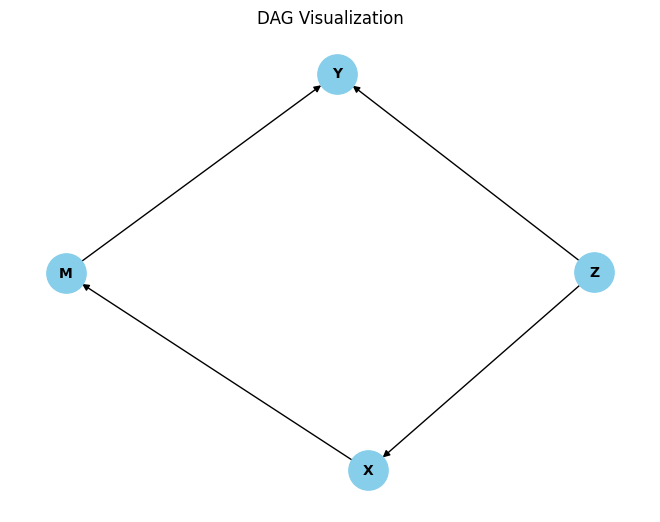

<IPython.core.display.Latex object>

In [69]:
# simple example digraph
# Define the edge pairs
edges = [("Z", "X"), ("X", "M"), ("M", "Y"), ("Z", "Y")]
G = nx.DiGraph()
G.add_edges_from(edges)

# display graph
pos = nx.spring_layout(G, seed=42)  # Layout for graph visualization
nx.draw(G, pos, with_labels=True, node_size=800, node_color='skyblue', font_size=10, font_color='black', font_weight='bold', arrows=True)
plt.title("DAG Visualization")
plt.show()

# create and print LSCM
LSCM_dict = generate_LSCM_from_DAG(G)
#display(LSCM_dict)

from IPython.display import Latex

# convert to latex
#eqn_array = convert_to_latex(LSCM_dict)
eqn_array2 = convert_to_eqn_array_latex(LSCM_dict)

#display(Latex(eqn_array))
display(Latex(eqn_array2))



None

{Z: epsilon_Z + gamma_X_<->Z,
 X: Z*beta_Z_->X + epsilon_X + gamma_X_<->Y + gamma_X_<->Z,
 M: X*beta_X_->M + epsilon_M,
 Y: M*beta_M_->Y + Z*beta_Z_->Y + epsilon_Y + gamma_X_<->Y}

<IPython.core.display.Latex object>

{('X', 'Z'): gamma_X_<->Z, ('X', 'Y'): gamma_X_<->Y}

{(Z, X): beta_Z_->X,
 (Z, Y): beta_Z_->Y,
 (X, M): beta_X_->M,
 (M, Y): beta_M_->Y}

{Z: epsilon_Z, X: epsilon_X, M: epsilon_M, Y: epsilon_Y}

{epsilon_Z: -0.5341630503807221,
 epsilon_X: 0.1019710538667895,
 epsilon_M: -0.19174073245707557,
 epsilon_Y: -0.40789391357733035}

{beta_Z_->X: -0.4848275448624537,
 beta_Z_->Y: -0.6442735616082793,
 beta_X_->M: -0.08274546984549103,
 beta_M_->Y: 0.2397932713541624}

{epsilon_Z: -0.5341630503807221,
 epsilon_X: 0.1019710538667895,
 epsilon_M: -0.19174073245707557,
 epsilon_Y: -0.40789391357733035,
 beta_Z_->X: -0.4848275448624537,
 beta_Z_->Y: -0.6442735616082793,
 beta_X_->M: -0.08274546984549103,
 beta_M_->Y: 0.2397932713541624,
 gamma_X_<->Z: -0.9440061172192873,
 gamma_X_<->Y: 0.46683268496625385}

[Eq(Z, -1.47816916760001), Eq(X, -0.484827544862454*Z - 0.375202378386244), Eq(M, -0.082745469845491*X - 0.191740732457076), Eq(Y, 0.239793271354162*M - 0.644273561608279*Z + 0.0589387713889235)]


{M: -0.219994566179502,
 X: 0.341454750032646,
 Y: 0.958530868953805,
 Z: -1.47816916760001}

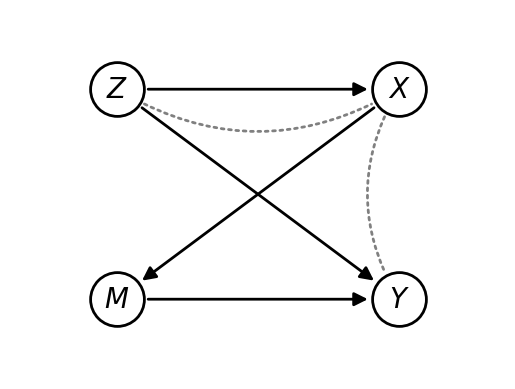

In [101]:
# mixed graph example
import numpy as np
# Define the edge pairs
edges = [("Z", "X"), ("X", "M"), ("M", "Y"), ("Z", "Y")]
bi_edges = [("X", "Y"), ("Z", "X")]
G = NxMixedGraph.from_str_edges(directed=edges, undirected=bi_edges)
display(G.draw())

# create and print LSCM
LSCM_dict = generate_LSCM_from_mixed_graph(G)
display(LSCM_dict)

# convert to latex
eqn_array = convert_to_eqn_array_latex(LSCM_dict)
display(Latex(eqn_array))

display(get_symbols_from_bi_edges(G))
display(get_symbols_from_di_edges(G))
display(get_symbols_from_nodes(G))


epsilon_symbols = get_symbols_from_nodes(G)
beta_symbols = get_symbols_from_di_edges(G)
gamma_symbols = get_symbols_from_bi_edges(G)
# create params dict
# for every edge create a random number (beta)
# for every node create a random number (epsilon)
epsilon_values = {epsilon:np.random.normal(0,1) for epsilon in epsilon_symbols.values()}
beta_values = {beta:np.random.uniform(-1,1) for beta in beta_symbols.values()}
gamma_values = {gamma:np.random.uniform(-1,1) for gamma in gamma_symbols.values()}
display(epsilon_values)
display(beta_values)

param_dict = {**epsilon_values, **beta_values, **gamma_values}

display(param_dict)

display(evaluate_LSCM(LSCM_dict,param_dict))

# create a params dictionary




None

{Z: epsilon_Z,
 X: Z*beta_Z_->X + epsilon_X,
 M: X*beta_X_->M + epsilon_M,
 Y: M*beta_M_->Y + Z*beta_Z_->Y + epsilon_Y}

<IPython.core.display.Latex object>

{}

{(Z, X): beta_Z_->X,
 (Z, Y): beta_Z_->Y,
 (X, M): beta_X_->M,
 (M, Y): beta_M_->Y}

{Z: epsilon_Z, X: epsilon_X, M: epsilon_M, Y: epsilon_Y}

{epsilon_Z: -1.5817733112184043,
 epsilon_X: -1.7252039286468284,
 epsilon_M: -1.0267927293379502,
 epsilon_Y: -0.3101235092308085}

{beta_Z_->X: 0.7595171580228741,
 beta_Z_->Y: -0.869721293061386,
 beta_X_->M: 0.5158483677317698,
 beta_M_->Y: 0.1759211748199152}

{epsilon_Z: -1.5817733112184043,
 epsilon_X: -1.7252039286468284,
 epsilon_M: -1.0267927293379502,
 epsilon_Y: -0.3101235092308085,
 beta_Z_->X: 0.7595171580228741,
 beta_Z_->Y: -0.869721293061386,
 beta_X_->M: 0.5158483677317698,
 beta_M_->Y: 0.1759211748199152}

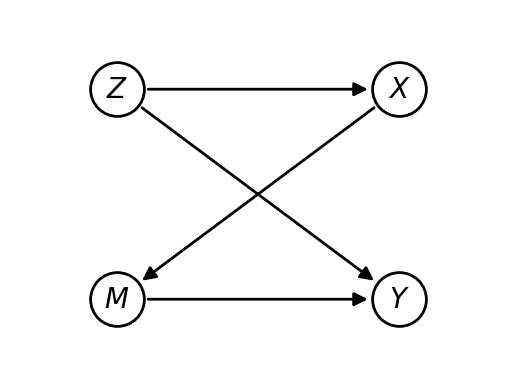

In [88]:
import numpy as np

# mixed graph example

# Define the edge pairs
edges = [("Z", "X"), ("X", "M"), ("M", "Y"), ("Z", "Y")]
bi_edges = []
G = NxMixedGraph.from_str_edges(directed=edges, undirected=bi_edges)
display(G.draw())

# create and print LSCM
LSCM_dict = generate_LSCM_from_mixed_graph(G)
display(LSCM_dict)

# convert to latex
eqn_array = convert_to_eqn_array_latex(LSCM_dict)
display(Latex(eqn_array))

display(get_symbols_from_bi_edges(G))
display(get_symbols_from_di_edges(G))
display(get_symbols_from_nodes(G))

epsilon_symbols = get_symbols_from_nodes(G)
beta_symbols = get_symbols_from_di_edges(G)
# create params dict
# for every edge create a random number (beta)
# for every node create a random number (epsilon)
epsilon_values = {epsilon:np.random.normal(0,1) for epsilon in epsilon_symbols.values()}
beta_values = {beta:np.random.uniform(-1,1) for beta in beta_symbols.values()}

display(epsilon_values)
display(beta_values)

param_dict = {**epsilon_values, **beta_values}

display(param_dict)



In [99]:
# partially update eqns

params = param_dict
LSCM = LSCM_dict

eqns = [sy.Eq(lhs.subs(params),rhs.subs(params)) for lhs,rhs in LSCM.items()]
print(eqns)
print(type(eqns))
print(type(eqns[0]))
print(sy.solve(eqns, list(LSCM)))

evaluate_LSCM(LSCM_dict,param_dict)


[Eq(Z, -1.5817733112184), Eq(X, 0.759517158022874*Z - 1.72520392864683), Eq(M, 0.51584836773177*X - 1.02679272933795), Eq(Y, 0.175921174819915*M - 0.869721293061386*Z - 0.310123509230809)]
<class 'list'>
<class 'sympy.core.relational.Equality'>
{M: -2.53646831986456, X: -2.92658789861986, Y: 0.619359933607979, Z: -1.58177331121840}
[Eq(Z, -1.5817733112184), Eq(X, 0.759517158022874*Z - 1.72520392864683), Eq(M, 0.51584836773177*X - 1.02679272933795), Eq(Y, 0.175921174819915*M - 0.869721293061386*Z - 0.310123509230809)]


{M: -2.53646831986456,
 X: -2.92658789861986,
 Y: 0.619359933607979,
 Z: -1.58177331121840}

None

<IPython.core.display.Latex object>

{epsilon_SARS_COV2: 1.0277068128655313,
 epsilon_ACE2: -0.5012071160861236,
 epsilon_Ang: -1.5119802638592266,
 epsilon_AGTR1: -1.7198061895299006,
 epsilon_ADAM17: 0.8139862947136257,
 epsilon_Toci: 1.4378481622962171,
 epsilon_Sil6r: 0.014502064901576161,
 epsilon_EGF: -1.260704875771836,
 epsilon_TNF: 0.6542024183190295,
 epsilon_EGFR: -1.5455308279710624,
 epsilon_PRR: 0.23386941437941006,
 epsilon_NFKB: 0.03385307646602402,
 epsilon_IL6STAT3: -0.8770134514800504,
 epsilon_IL6AMP: 1.0236888646034423,
 epsilon_cytok: 1.0968786505011578,
 epsilon_Gefi: 0.735354898933018}

{beta_SARS_COV2_->ACE2: 0.14057192762498572,
 beta_SARS_COV2_->PRR: -0.7712539630824196,
 beta_ACE2_->Ang: -0.9754446865570303,
 beta_Ang_->AGTR1: 0.2695726545286663,
 beta_AGTR1_->ADAM17: 0.12749171972076723,
 beta_ADAM17_->EGF: -0.5256084623504855,
 beta_ADAM17_->TNF: 0.782076127053525,
 beta_ADAM17_->Sil6r: -0.921859571898489,
 beta_Toci_->Sil6r: 0.5807645316560621,
 beta_Sil6r_->IL6STAT3: -0.810848245858034,
 beta_EGF_->EGFR: -0.331809062086029,
 beta_TNF_->NFKB: 0.009557559789158843,
 beta_EGFR_->NFKB: 0.23072764268506107,
 beta_PRR_->NFKB: -0.530309687309201,
 beta_NFKB_->IL6AMP: 0.23745879781946577,
 beta_IL6STAT3_->IL6AMP: -0.9696450277215005,
 beta_IL6AMP_->cytok: 0.310703599305044,
 beta_Gefi_->EGFR: -0.36770883819431566}

{epsilon_SARS_COV2: 1.0277068128655313,
 epsilon_ACE2: -0.5012071160861236,
 epsilon_Ang: -1.5119802638592266,
 epsilon_AGTR1: -1.7198061895299006,
 epsilon_ADAM17: 0.8139862947136257,
 epsilon_Toci: 1.4378481622962171,
 epsilon_Sil6r: 0.014502064901576161,
 epsilon_EGF: -1.260704875771836,
 epsilon_TNF: 0.6542024183190295,
 epsilon_EGFR: -1.5455308279710624,
 epsilon_PRR: 0.23386941437941006,
 epsilon_NFKB: 0.03385307646602402,
 epsilon_IL6STAT3: -0.8770134514800504,
 epsilon_IL6AMP: 1.0236888646034423,
 epsilon_cytok: 1.0968786505011578,
 epsilon_Gefi: 0.735354898933018,
 beta_SARS_COV2_->ACE2: 0.14057192762498572,
 beta_SARS_COV2_->PRR: -0.7712539630824196,
 beta_ACE2_->Ang: -0.9754446865570303,
 beta_Ang_->AGTR1: 0.2695726545286663,
 beta_AGTR1_->ADAM17: 0.12749171972076723,
 beta_ADAM17_->EGF: -0.5256084623504855,
 beta_ADAM17_->TNF: 0.782076127053525,
 beta_ADAM17_->Sil6r: -0.921859571898489,
 beta_Toci_->Sil6r: 0.5807645316560621,
 beta_Sil6r_->IL6STAT3: -0.810848245858034,
 bet

[Eq(SARS_COV2, 0.944577652252988), Eq(Toci, 1.43784816229622), Eq(Gefi, 0.735354898933018), Eq(ACE2, 0.140571927624986*SARS_COV2 - 0.501207116086124), Eq(PRR, -0.77125396308242*SARS_COV2 - 0.653903283501172), Eq(Ang, -0.97544468655703*ACE2 - 1.59510942447177), Eq(AGTR1, 0.269572654528666*Ang - 1.7198061895299), Eq(ADAM17, 0.127491719720767*AGTR1 + 1.61591168487688), Eq(EGF, -0.525608462350486*ADAM17 - 1.5578492168105), Eq(TNF, 0.782076127053525*ADAM17 + 0.319588754446042), Eq(Sil6r, -0.921859571898489*ADAM17 + 0.580764531656062*Toci + 0.816427455064828), Eq(EGFR, -0.331809062086029*EGF - 0.367708838194316*Gefi - 3.12620228023861), Eq(IL6STAT3, -0.810848245858034*Sil6r - 1.82592689883594), Eq(NFKB, 0.230727642685061*EGFR - 0.530309687309201*PRR + 0.00955755978915884*TNF - 0.853919621414558), Eq(IL6AMP, -0.969645027721501*IL6STAT3 + 0.237458797819466*NFKB + 1.02368886460344), Eq(cytok, 0.310703599305044*IL6AMP + 1.09687865050116)]


{ACE2: -0.368426014717438,
 ADAM17: 1.35418071214909,
 AGTR1: -2.05292526684111,
 Ang: -1.23573022602626,
 EGF: -2.26961805866787,
 EGFR: -2.64351893644567,
 Gefi: 0.735354898933018,
 IL6AMP: 2.94073919870249,
 IL6STAT3: -2.15279135542900,
 NFKB: -0.717569115059953,
 PRR: -1.38241254124038,
 SARS_COV2: 0.944577652252988,
 Sil6r: 0.403114218058368,
 TNF: 1.37866116113419,
 Toci: 1.43784816229622,
 cytok: 2.01057690415545}

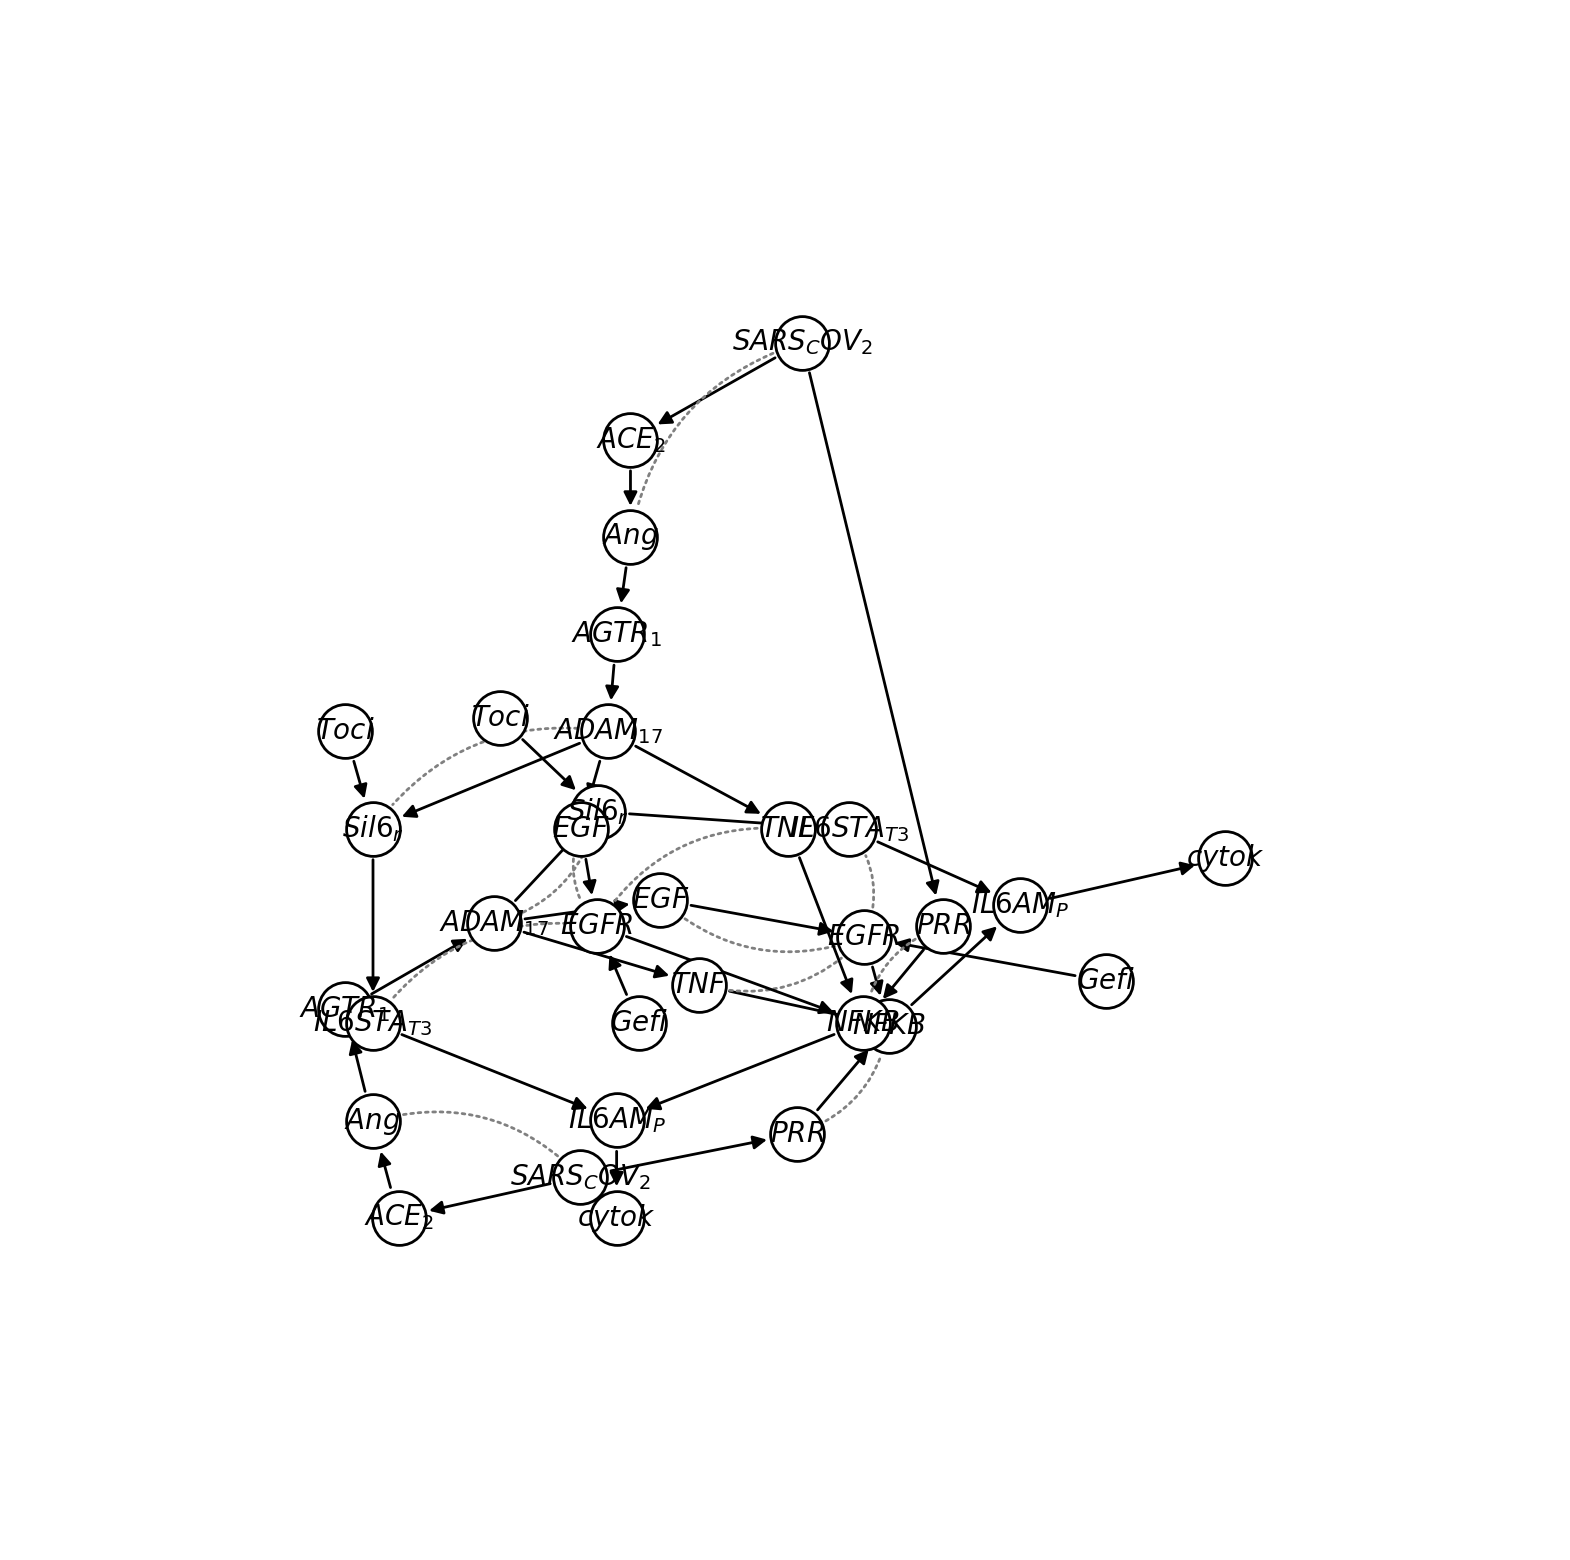

In [104]:
from y0.examples import sars_large_example

G = sars_large_example.graph
fig, ax = plt.subplots(figsize=(20, 20))
G.draw(ax, prog='neato')
display(G.draw())

# create and print LSCM
LSCM_dict = generate_LSCM_from_mixed_graph(G)
#display(LSCM_dict)

# convert to latex
eqn_array = convert_to_eqn_array_latex(LSCM_dict)
display(Latex(eqn_array))

epsilon_symbols = get_symbols_from_nodes(G)
beta_symbols = get_symbols_from_di_edges(G)
gamma_symbols = get_symbols_from_bi_edges(G)
# create params dict
# for every edge create a random number (beta)
# for every node create a random number (epsilon)
epsilon_values = {epsilon:np.random.normal(0,1) for epsilon in epsilon_symbols.values()}
beta_values = {beta:np.random.uniform(-1,1) for beta in beta_symbols.values()}
gamma_values = {gamma:np.random.uniform(-1,1) for gamma in gamma_symbols.values()}
display(epsilon_values)
display(beta_values)

param_dict = {**epsilon_values, **beta_values, **gamma_values}

display(param_dict)

display(evaluate_LSCM(LSCM_dict,param_dict))

None

<IPython.core.display.Latex object>

[Eq(slyB, -0.4156502751408), Eq(betI, -0.784297678737556), Eq(uvrA, 0.530080257857695), Eq(astC, 1.10791366299653), Eq(metL, -1.11933078296513), Eq(lldD, 1.25741117885695), Eq(fadB, 1.03865587436349), Eq(ddpC, 0.712755659458437*slyB + 0.395014764857728), Eq(rutR, 0.641235678007738*astC + 0.89763283488359*metL - 0.0711457274068763*uvrA + 1.21091415506837), Eq(hybC, 0.0489838726731271*astC - 0.370906126832935*metL - 0.530656229969198*uvrA + 0.823757118153773), Eq(pagP, 0.563241623248286*betI + 0.313805429799676*ddpC + 0.635073313458338), Eq(treR, 0.143503066157135*ddpC + 0.711153750630081*slyB - 0.566654630272986), Eq(argR, -0.761731956625205*betI - 0.674571946787314*ddpC + 0.103428638153509), Eq(artJ, -0.172318711987725*betI - 0.693458692550369*ddpC - 0.778213331235814), Eq(hisP, -0.23544801955934*betI + 0.910330316979871*ddpC - 0.644419451274219*lldD - 0.716307685686867), Eq(mgtA, 0.703565524588177*betI - 0.77837852458808*ddpC - 0.23722878799209*lldD + 1.27477153483877), Eq(fadA, 0.776

{ackA: 1.87346428723966,
 appA: -0.282967110390904,
 appB: -1.04181125915145,
 appC: 1.78200374829146,
 arcA: 1.04073303672819,
 argA: 2.03808702536191,
 argD: -0.230539528384886,
 argF: 1.40020077624598,
 argI: -0.711851872611468,
 argR: 0.634234083842028,
 argT: 1.13121841254521,
 artI: 2.27473926410861,
 artJ: -0.711548536307094,
 artM: 0.102634388032683,
 astA: -1.07068163129021,
 astB: 1.54976545718219,
 astC: 1.10791366299653,
 astD: 3.37847531788464,
 astE: -0.239361971995903,
 betA: 2.61039859646806,
 betB: -1.64403089612216,
 betI: -0.784297678737556,
 betT: -0.0606679887406286,
 borD: -0.657814921858186,
 carA: 1.04868470765238,
 dcuC: -0.362966289440077,
 ddpA: -2.42620881681894,
 ddpB: -0.805564635480680,
 ddpC: 0.0987576788956663,
 ddpD: 1.56616216277103,
 ddpF: 1.12157420830199,
 ddpX: -1.14156536146287,
 fadA: 0.407219757308524,
 fadB: 1.03865587436349,
 fadI: 1.26497535451436,
 fadJ: 1.70886573547206,
 fadL: -0.868193793866048,
 fadR: 0.270107421034456,
 fepB: -0.804284

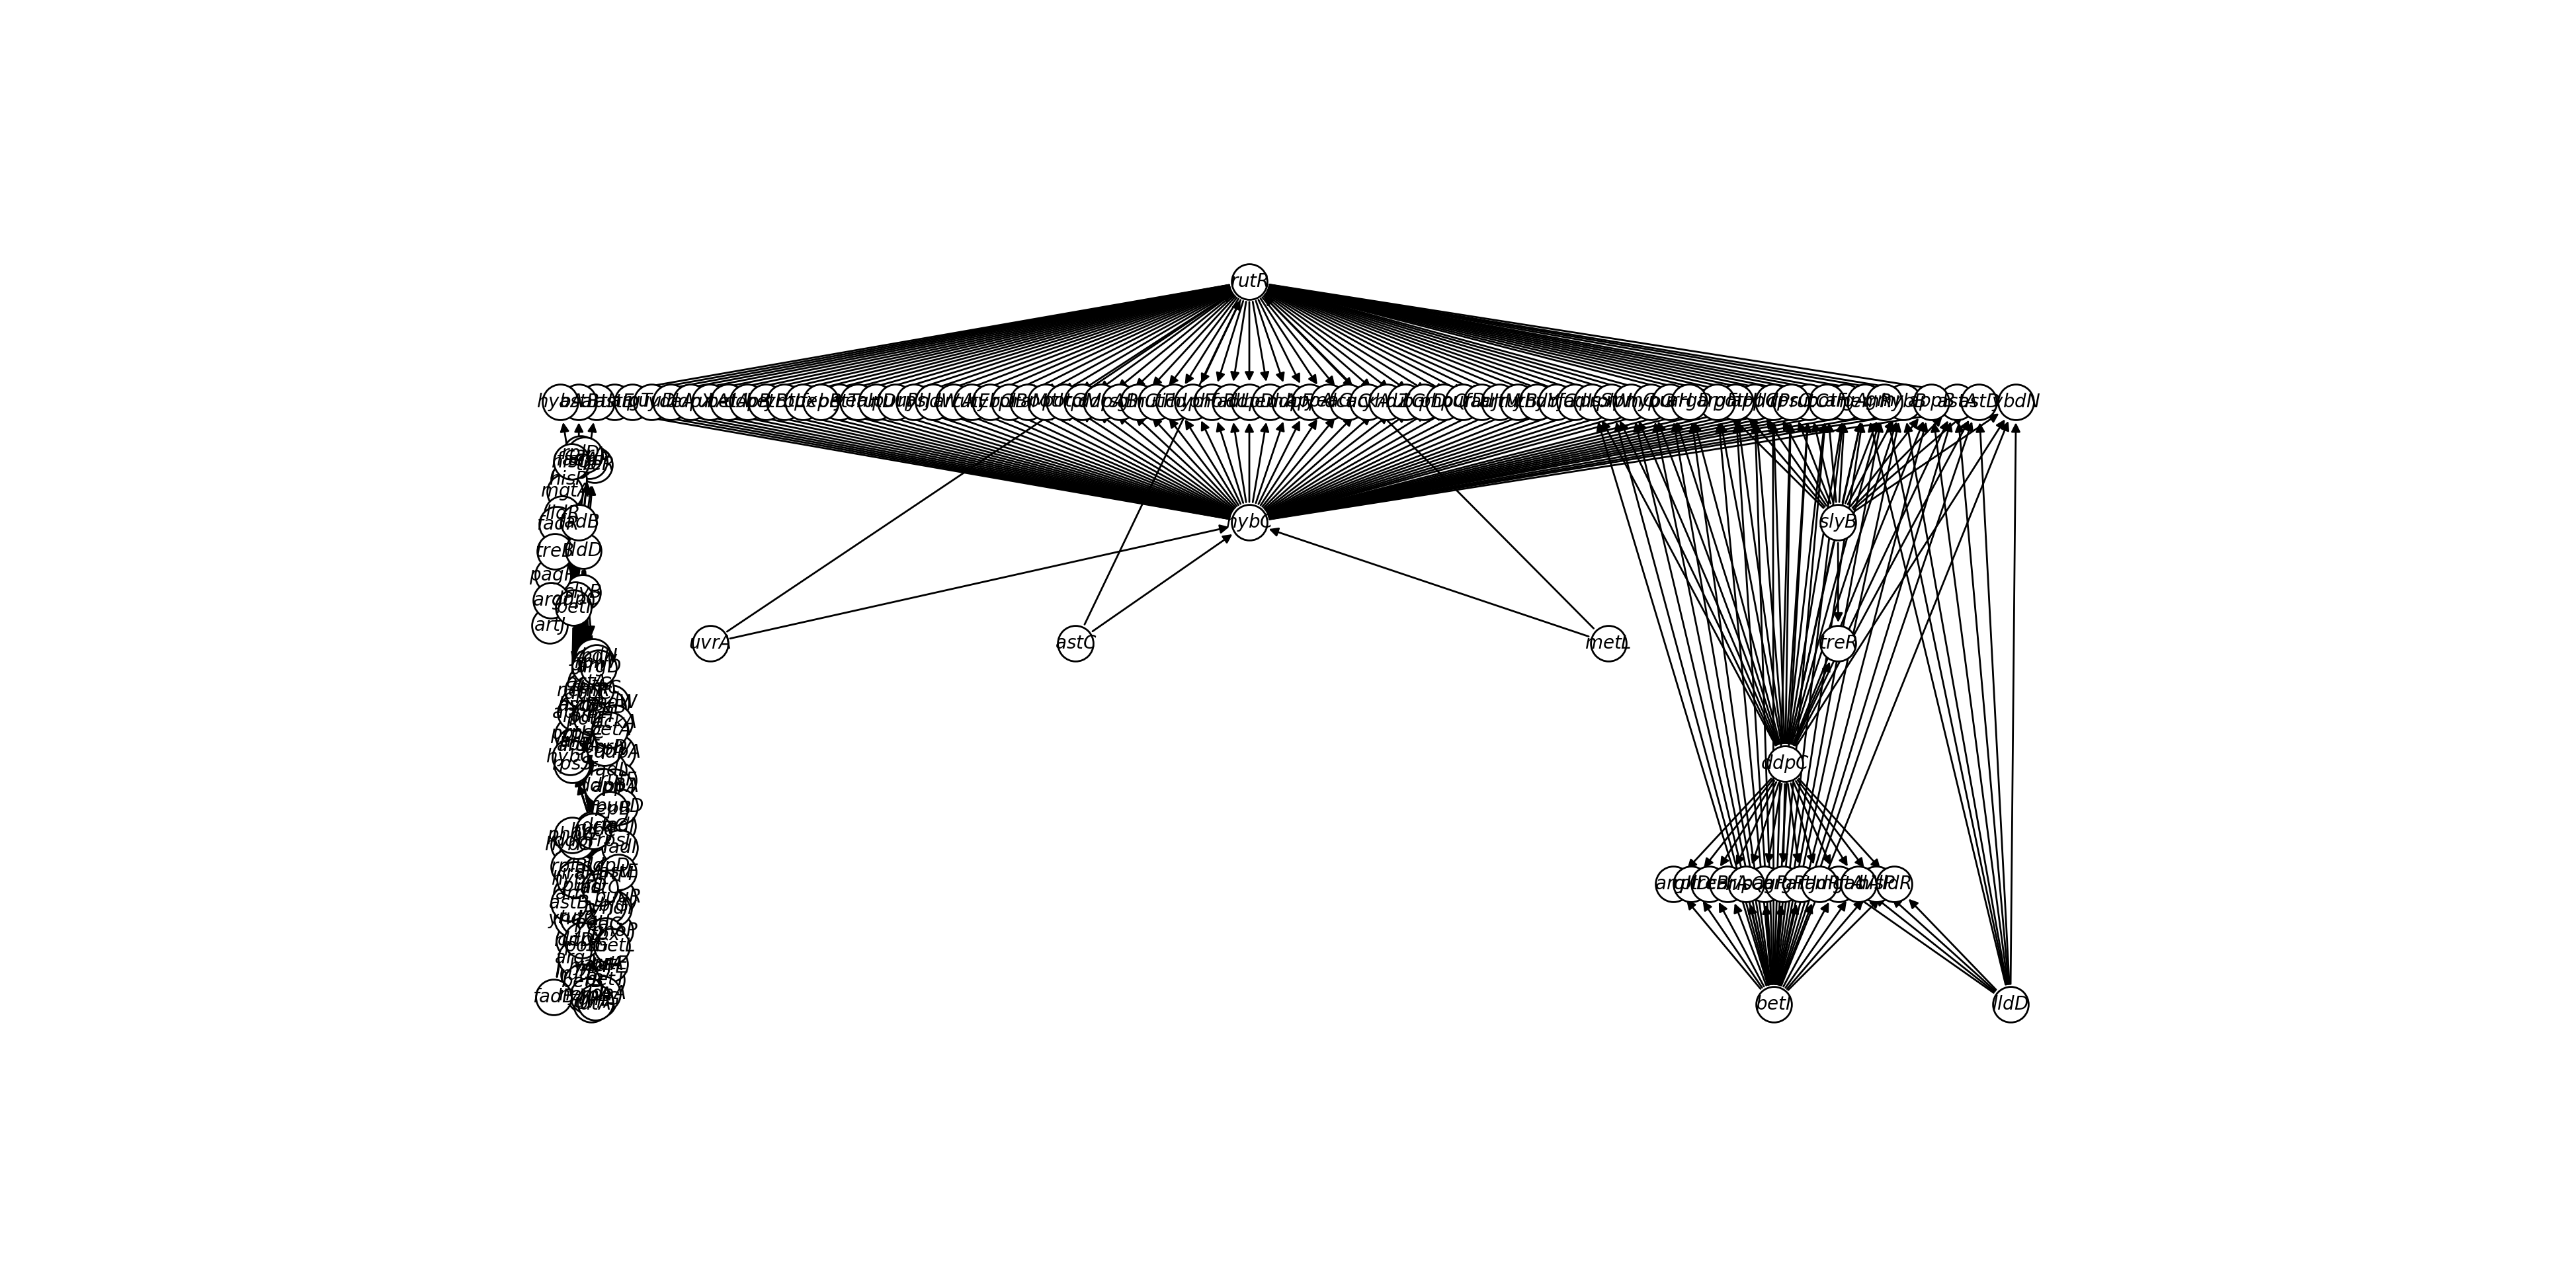

In [119]:
# ecoli

G = dagitty_to_mixed_graph('DS1.dag') # ~ 100 equations 
fig, ax = plt.subplots(figsize=(50, 25))
#pos = nx.spring_layout(ecoli_digraph)
#nx.draw(ecoli_digraph, pos, with_labels=True, node_size=2000, node_color='lightblue', font_size=15)
G.draw(ax, prog='neato')
display(G.draw())


# LSCM from DAG

LSCM_dict = generate_LSCM_from_mixed_graph(G)
#display(LSCM_dict)

# convert to latex
eqn_array = convert_to_latex(LSCM_dict)
eqn_array2 = convert_to_eqn_array_latex(LSCM_dict)

#display(Latex(eqn_array))
display(Latex(eqn_array2))

# generate random parameter values and solve
epsilon_symbols = get_symbols_from_nodes(G)
beta_symbols = get_symbols_from_di_edges(G)
gamma_symbols = get_symbols_from_bi_edges(G)
epsilon_values = {epsilon:np.random.normal(0,1) for epsilon in epsilon_symbols.values()}
beta_values = {beta:np.random.uniform(-1,1) for beta in beta_symbols.values()}
gamma_values = {gamma:np.random.uniform(-1,1) for gamma in gamma_symbols.values()}
param_dict = {**epsilon_values, **beta_values, **gamma_values}
display(evaluate_LSCM(LSCM_dict,param_dict))

In [42]:
# loading daggity example
test_graph = '''dag {
bb="0,0,1,1"
"Z" [pos="0.5,0.9"]
"Y" [pos="0.1,0.5"]
"X" [pos="0.9,0.5"]
"M" [pos="0.5,0.1"]
"Z" -> "Y"
"Z" -> "X"
"M" -> "Y"
"X" -> "M"
}'''

test_dagitty_to_mixed_graph(test_graph, "frontdoor_backdoor.dag")  # test graphs are the same using string or file


# the frontdoor_backdoor eliator model isn't equal to the dagitty version - CHECK THIS
mixed_graph = dagitty_to_mixed_graph(test_graph)
example_graph = frontdoor_backdoor_example.graph

print(mixed_graphs_equal(mixed_graph,example_graph))
print(mixed_graph.directed.nodes)
print(example_graph.directed.nodes)

True
[Z, Y, X, M]
[Z, X, M, Y]


# Generating data from linear structural casual models 



# Estimating parameters using single-door criterion

For each edge in DAG:
1. calculate single-door criterion for source and target node conditional on adjustement set
2. Add that regression coefficent to the edge of that linear SCM


# ~OLD~

## Running Eliater demo regression problem
from: https://github.com/y0-causal-inference/eliater/blob/linear-regression/src/eliater/regression.py 


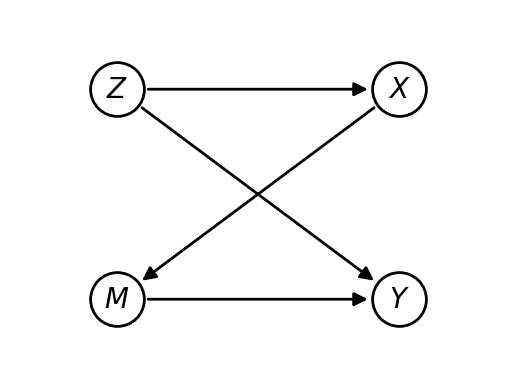

{Y: {frozenset({Z}): {X: 0.1784942372933808, Z: 0.39068902276154}}}

In [19]:
from eliater.regression import get_regression_coefficients
from eliater.frontdoor_backdoor import frontdoor_backdoor_example
from y0.dsl import X, Y, Z, M
from y0.graph import NxMixedGraph

import matplotlib.pyplot as plt 
import numpy as np


graph = frontdoor_backdoor_example.graph
graph = NxMixedGraph.from_edges(directed=[(Z, X), (X, M), (M, Y), (Z, Y)])


data = frontdoor_backdoor_example.generate_data(1000)  # review data generation process
treatments = {X}
outcome = Y
coefficients = get_regression_coefficients(
    graph=graph, data=data, treatments=treatments, outcomes=outcome
)

# for each edge in DAG
# calculate single door criterion

graph.draw()
plt.show()
display(coefficients)  # noqa:T201

# todo:
# can NxMixedGraph read in daggity? (need a better way to specify models, read in textfile)
# randomly generate coefficients (+/-) and synthesize data
# given complete graph how much data is needed to estimate coefficients (assuming no noise)
# given complete graph how much data is needed to estimate coefficients (with noise)
# how to integrate w/ SERGIO (different sources of uncertainity for single cell data)

# parsing a daggity graph

In [5]:
import re
import networkx as nx
import os 


#!pip install pydot
import pydot
from networkx.drawing.nx_pydot import from_pydot
from y0.graph import NxMixedGraph
import matplotlib.pyplot as plt
from eliater.frontdoor_backdoor import frontdoor_backdoor_example



def daggity_to_dot(daggity_string):
    """
    Modified from dowhy: https://www.pywhy.org/dowhy/v0.11.1/_modules/dowhy/utils/graph_operations.html#daggity_to_dot  
    Converts the input daggity_string to valid DOT graph format.

    :param daggity_string: Output graph from Daggity site
    :returns: DOT string
    """

    graph = re.sub(r"\n", "; ", daggity_string)
    graph = re.sub(r"^dag ", "digraph ", graph)
    graph = re.sub("{;", "{", graph)
    graph = re.sub("};", "}", graph)
    graph = re.sub("outcome,*,", "", graph)
    graph = re.sub("adjusted,*", "", graph)
    graph = re.sub("exposure,*", "", graph)
    graph = re.sub("latent,*", 'observed="no",', graph)
    graph = re.sub(",]", "]", graph)
    graph = re.sub(r'bb="[\d.,]+";?', '', graph)  # Remove bb line with four numbers and optional trailing semicolon
    return graph


def read_dag_file(file_path):
    """Reads the contents of a .dag file and returns it as a multiline string."""
    try:
        with open(file_path, 'r') as file:
            return file.read()
    except IOError as e:
        print(f"Error reading file: {e}")
        return None


def dagitty_to_mixed_graph(dagitty_input, str_var_name = False) -> NxMixedGraph:
    """Converts a string in dagitty (.dag) to NxMixedGraph """

    # Check if the input is a file path
    if os.path.isfile(dagitty_input):
        dagitty_graph_str = read_dag_file(dagitty_input)
    else:
        dagitty_graph_str = dagitty_input

    # .dag string -> DOT -> networkx -> NxMixedGraph
    dot_graph_string = daggity_to_dot(dagitty_graph_str)
    dot_graph = pydot.graph_from_dot_data(dot_graph_string)[0]
    nx_graph = from_pydot(dot_graph)
    if str_var_name:
        mixed_graph = NxMixedGraph.from_edges(directed=[ (u,v) for u,v,d in nx_graph.edges]) # convert from str to variable
    else:
        mixed_graph = NxMixedGraph.from_str_edges(directed=[ (u,v) for u,v,d in nx_graph.edges]) # convert from str to variable
    return mixed_graph

def dagitty_to_digraph(dagitty_input) -> nx.DiGraph:
    """Converts a string in dagitty (.dag) to NX DiGraph """

    # Check if the input is a file path
    if os.path.isfile(dagitty_input):
        dagitty_graph_str = read_dag_file(dagitty_input)
    else:
        dagitty_graph_str = dagitty_input

    # .dag string -> DOT -> networkx -> NxMixedGraph
    dot_graph_string = daggity_to_dot(dagitty_graph_str)
    dot_graph = pydot.graph_from_dot_data(dot_graph_string)[0]
    nx_graph = from_pydot(dot_graph)
    assert isinstance(nx_graph,nx.DiGraph)
    return nx_graph


def mixed_graphs_equal(G1:NxMixedGraph, G2:NxMixedGraph) -> bool:
    """Tests if two mixed graphs are equal"""
    if nx.utils.graphs_equal(G1.undirected, G2.undirected) and nx.utils.graphs_equal(G1.directed,G2.directed):
        return True
    else:
        return False


def test_dagitty_to_mixed_graph(test_graph_str, test_graph_file):
    # test resulting graphs are the same when using daggity string or file 
    mixed_graph1 = dagitty_to_mixed_graph(test_graph_str)
    mixed_graph2 = dagitty_to_mixed_graph(test_graph_file)
    assert(mixed_graphs_equal(mixed_graph1, mixed_graph2)==True)

test_graph = '''dag {
bb="0,0,1,1"
"Z" [pos="0.5,0.9"]
"Y" [pos="0.1,0.5"]
"X" [pos="0.9,0.5"]
"M" [pos="0.5,0.1"]
"Z" -> "Y"
"Z" -> "X"
"M" -> "Y"
"X" -> "M"
}'''

test_dagitty_to_mixed_graph(test_graph, "frontdoor_backdoor.dag")  # test graphs are the same using string or file


# the frontdoor_backdoor eliator model isn't equal to the dagitty version - CHECK THIS
mixed_graph = dagitty_to_mixed_graph(test_graph)
example_graph = frontdoor_backdoor_example.graph

print(mixed_graphs_equal(mixed_graph,example_graph))
print(mixed_graph.directed.nodes)
print(example_graph.directed.nodes)

True
[Z, Y, X, M]
[Z, X, M, Y]


In [ ]:
# problem: assuming a linear model, we want to intervene on the model variables, generate (or observe) data from that intervention, estimate coefficients

# possible solutions:
# ANANKE -  
# Probablistic program w/ causal dependencies (i.e. pymc w/ do operator)
# DAG - remove incoming edges from the intervening node(s) and set intervening variables to constants, generate data, then linear regression


# casual workflow
# 1. get data
# 2. get DAG 
# 3. validate DAG and data (structural identifiablity)
# 4. check if query is identifiable (y0, no unobserved confounders)
# 5. if identifiable - modify DAG and generate data and linear regression 
# 5a. do casual inference - given intervention and non-intervention data
# 6. if not identifiable - get bounds or gather data or add assumptions 


In [ ]:
# later: do sympy for symbolic

# generalized linear structural model generator (linear scm)
# set random seed
# set number of random samples
# create empty dictionary
# topologically sort the network - https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.dag.topological_sort.html # only works for DAG 
# start at top
# get parents
# now child = randN * parent 1 + randN * parent 2 + ... + bias Norm(0, 1, size=number of samples) for parent in parents 
# add child to dictionary
# convert into dataframe

def generate_linear_structural_model(G):
    pass

def generate_data_from_linear_structural_model(G):
    pass

# next steps:
# 1) function generate LSCM and data
# 2) linear regression on a toy model 


### loading a larger model
from jupyter lab dagitty example
https://github.com/krassowski/jupyterlab-dagitty/blob/main/examples/car_model_driver.dag

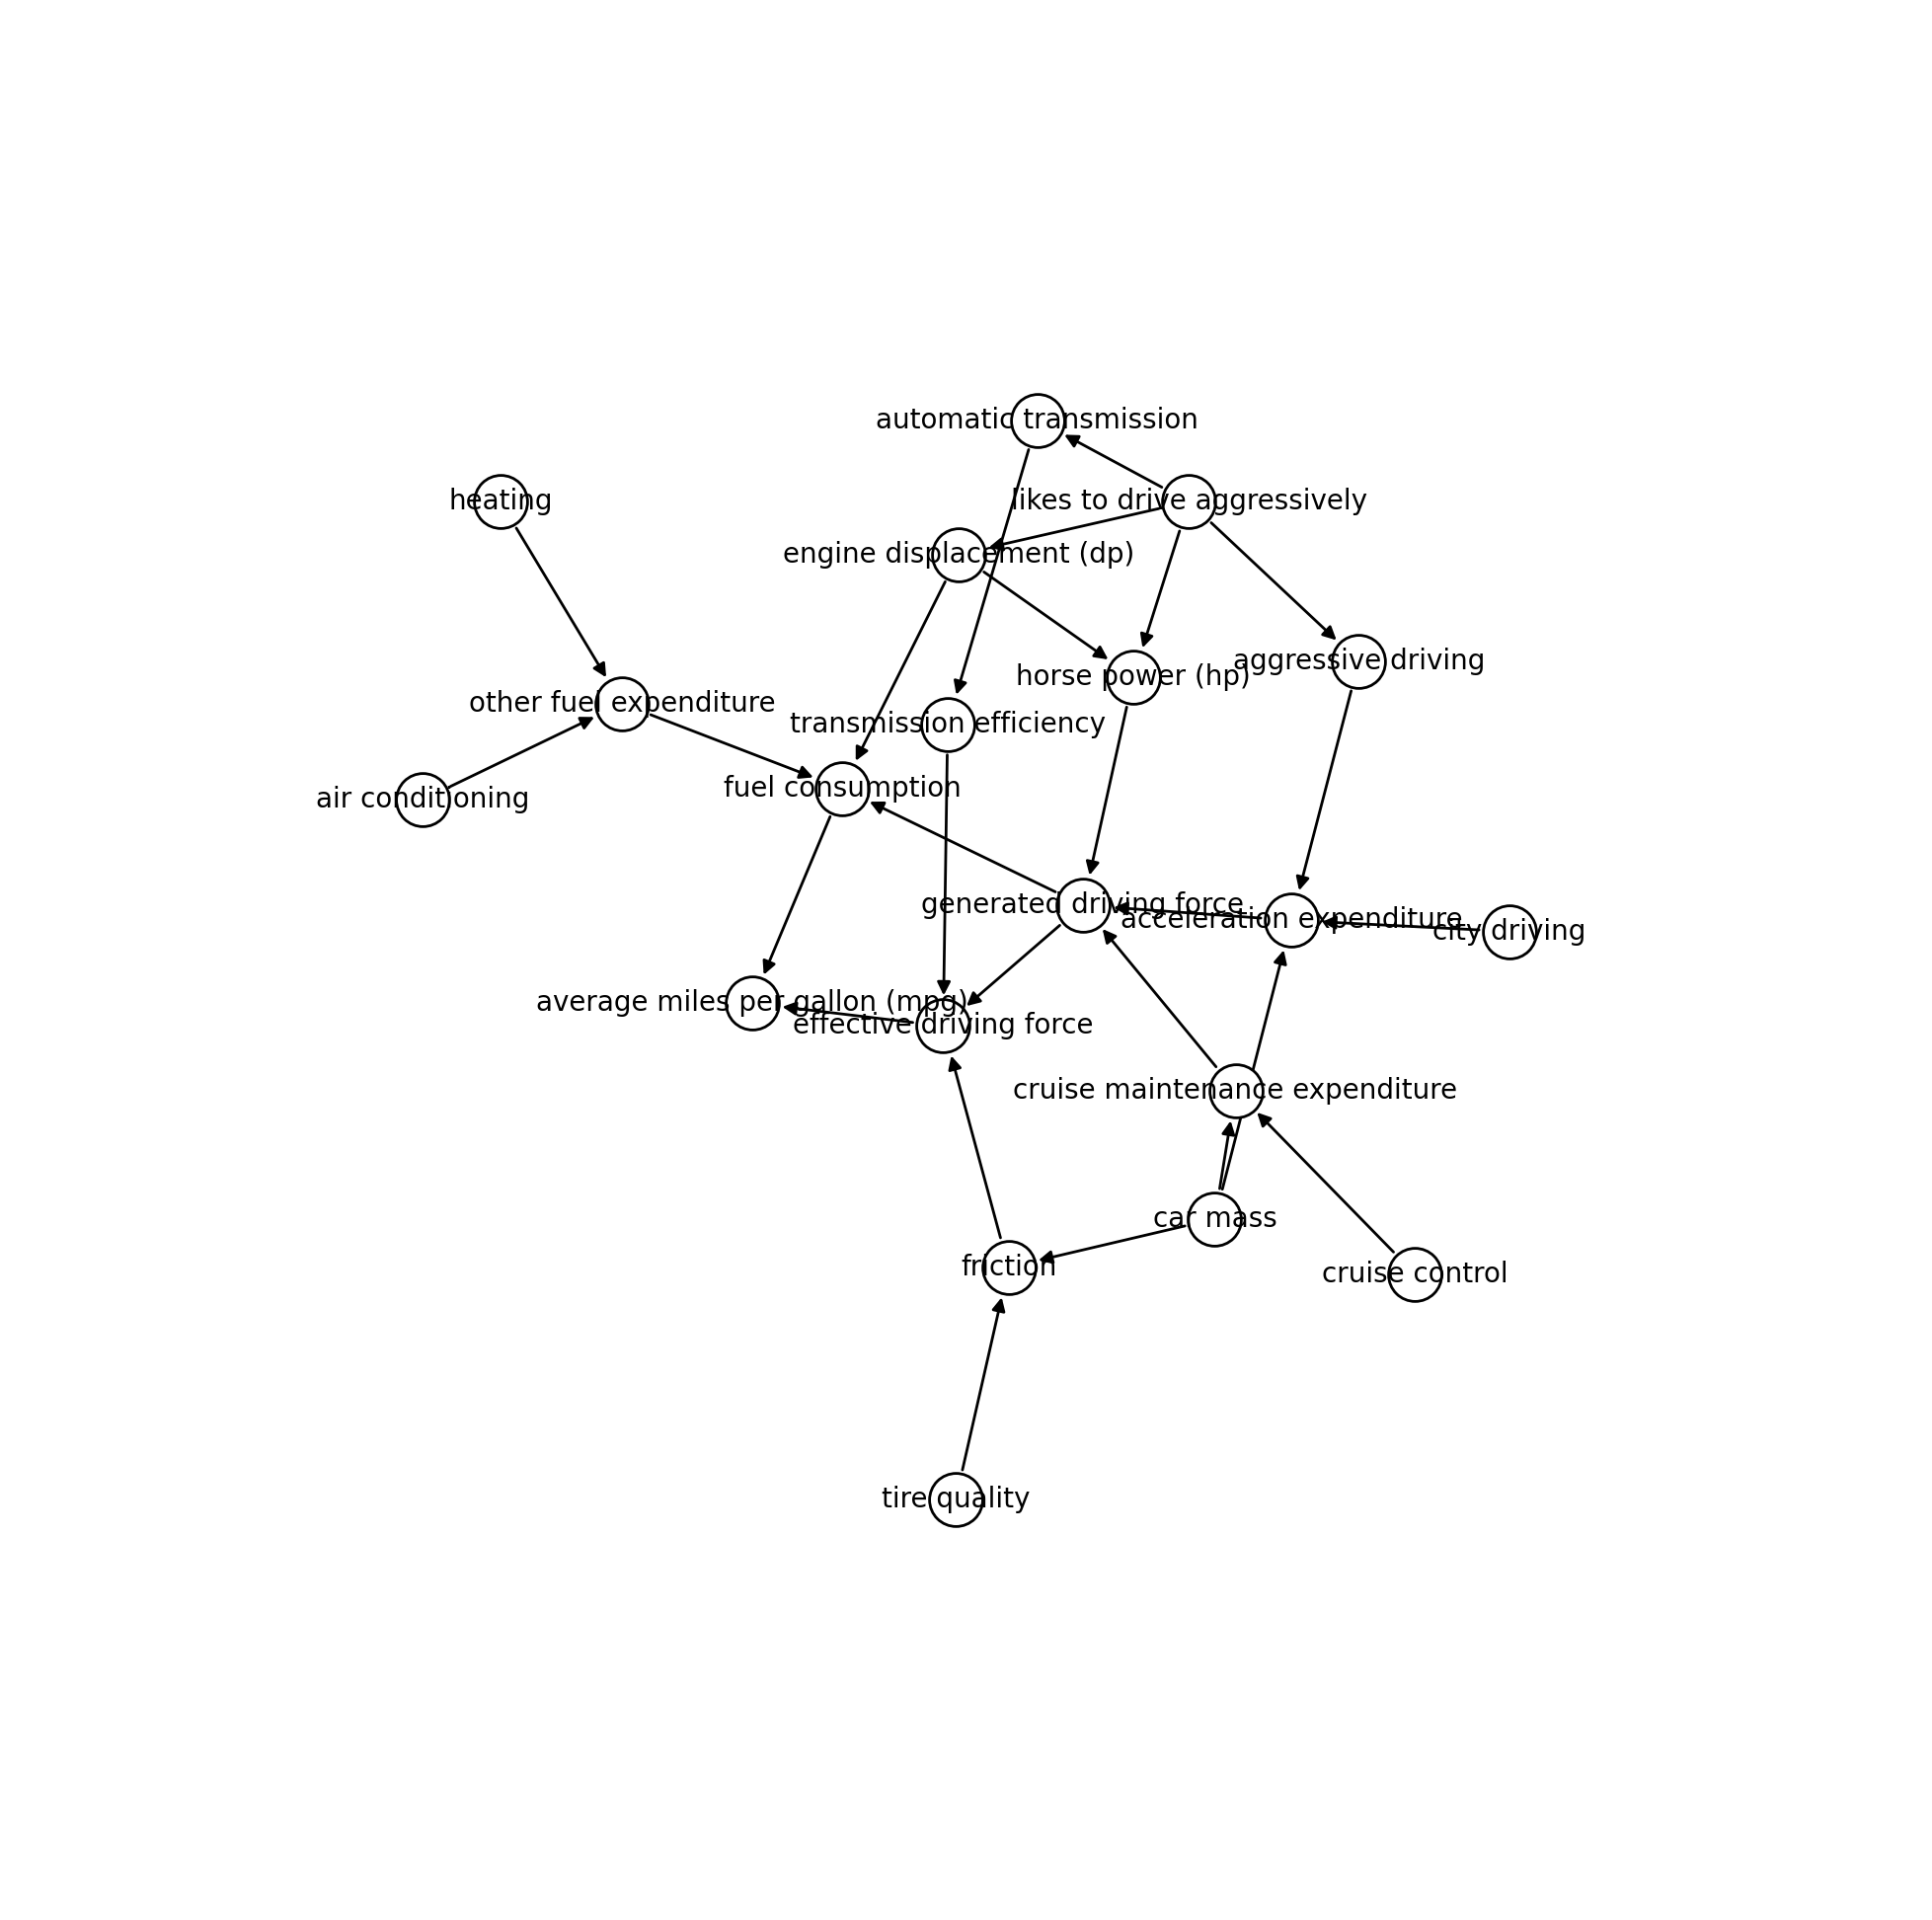

In [47]:
dag_str = '''dag {
bb="0,0,1,1"
"acceleration expenditure" [pos="0.649,0.534"]
"aggressive driving" [pos="0.510,0.543"]
"air conditioning" [pos="0.515,0.898"]
"automatic transmission" [pos="0.830,0.127"]
"average miles per gallon (mpg)" [outcome,pos="0.902,0.579"]
"car mass" [pos="0.546,0.281"]
"city driving" [pos="0.510,0.446"]
"cruise control" [pos="0.510,0.366"]
"cruise maintenance expenditure" [pos="0.630,0.404"]
"effective driving force" [pos="0.859,0.467"]
"engine displacement (dp)" [exposure,pos="0.636,0.724"]
"fuel consumption" [pos="0.798,0.674"]
"generated driving force" [pos="0.735,0.464"]
"horse power (hp)" [pos="0.694,0.629"]
"likes to drive aggressively" [pos="0.334,0.505"]
"other fuel expenditure" [pos="0.638,0.898"]
"tire quality" [pos="0.722,0.233"]
"transmission efficiency" [pos="0.840,0.267"]
friction [pos="0.758,0.342"]
heating [pos="0.514,0.809"]
"acceleration expenditure" -> "generated driving force"
"aggressive driving" -> "acceleration expenditure"
"air conditioning" -> "other fuel expenditure"
"automatic transmission" -> "transmission efficiency"
"car mass" -> "acceleration expenditure"
"car mass" -> "cruise maintenance expenditure"
"car mass" -> friction
"city driving" -> "acceleration expenditure"
"cruise control" -> "cruise maintenance expenditure"
"cruise maintenance expenditure" -> "generated driving force"
"effective driving force" -> "average miles per gallon (mpg)"
"engine displacement (dp)" -> "fuel consumption"
"engine displacement (dp)" -> "horse power (hp)"
"fuel consumption" -> "average miles per gallon (mpg)"
"generated driving force" -> "effective driving force"
"generated driving force" -> "fuel consumption"
"horse power (hp)" -> "generated driving force"
"likes to drive aggressively" -> "aggressive driving"
"likes to drive aggressively" -> "automatic transmission" [pos="0.332,0.090"]
"likes to drive aggressively" -> "engine displacement (dp)" [pos="0.351,0.745"]
"likes to drive aggressively" -> "horse power (hp)" [pos="0.439,0.703"]
"other fuel expenditure" -> "fuel consumption"
"tire quality" -> friction
"transmission efficiency" -> "effective driving force"
friction -> "effective driving force"
heating -> "other fuel expenditure"
}'''


mixed_graph = dagitty_to_mixed_graph(dag_str)

fig, ax = plt.subplots(figsize=(25, 25))
mixed_graph.draw(ax,prog='neato')
plt.show()

In [50]:
# next, generate data and do regression
# see frontdoor_backdoor example: https://github.com/y0-causal-inference/eliater/blob/linear-regression/src/eliater/frontdoor_backdoor/base.py 

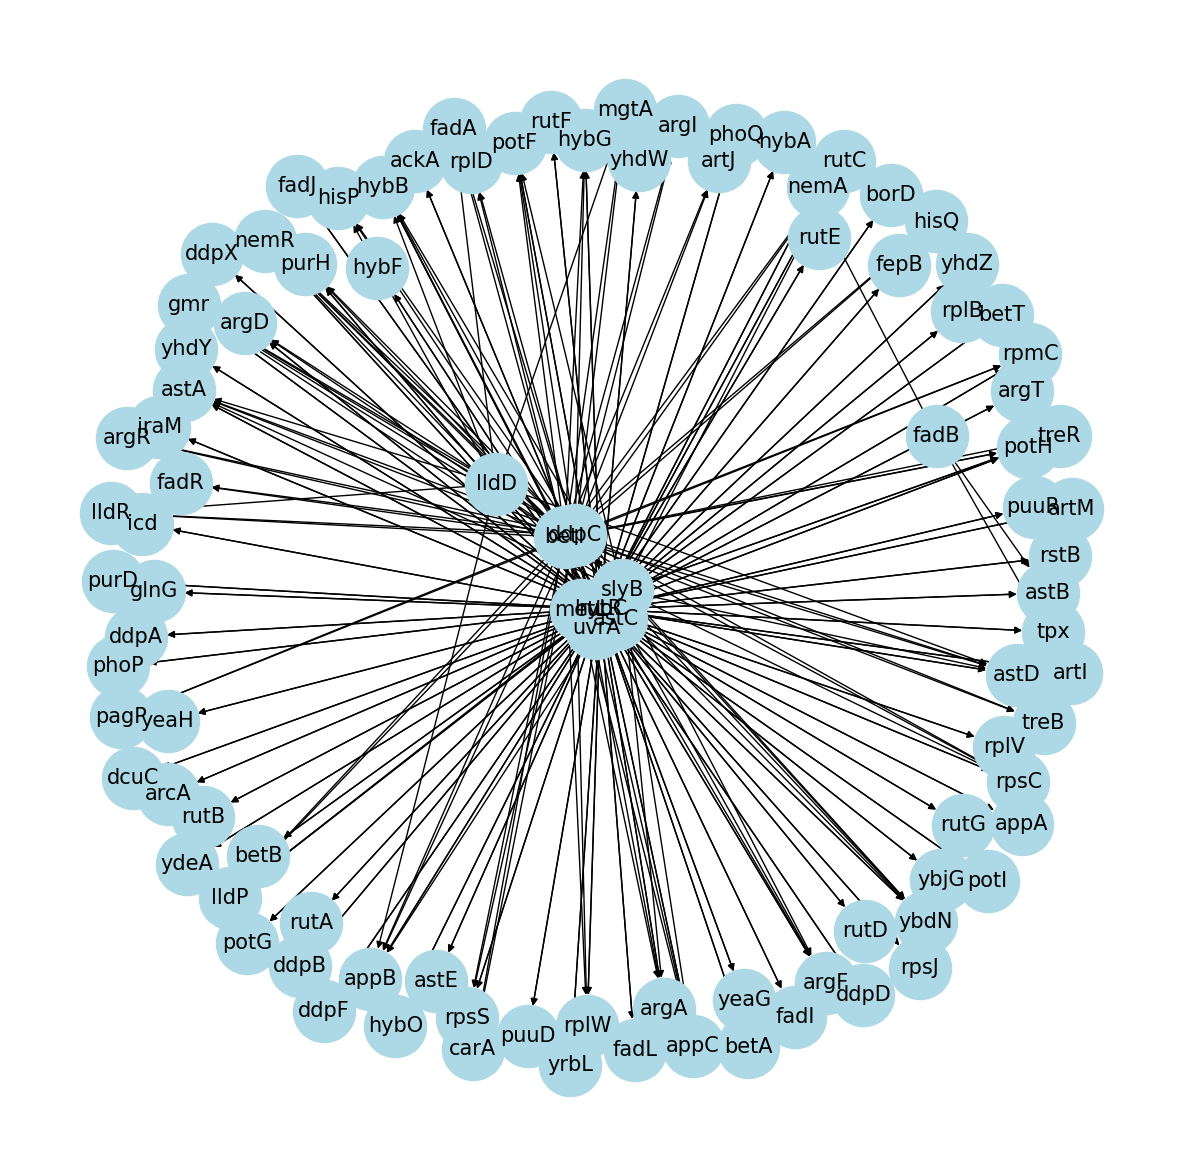

{slyB: epsilon_slyB,
 betI: epsilon_betI,
 uvrA: epsilon_uvrA,
 astC: epsilon_astC,
 metL: epsilon_metL,
 lldD: epsilon_lldD,
 fadB: epsilon_fadB,
 ddpC: beta_slyB_->ddpC*slyB + epsilon_ddpC,
 rutR: astC*beta_astC_->rutR + beta_metL_->rutR*metL + beta_uvrA_->rutR*uvrA + epsilon_rutR,
 hybC: astC*beta_astC_->hybC + beta_metL_->hybC*metL + beta_uvrA_->hybC*uvrA + epsilon_hybC,
 pagP: betI*beta_betI_->pagP + beta_ddpC_->pagP*ddpC + epsilon_pagP,
 treR: beta_ddpC_->treR*ddpC + beta_slyB_->treR*slyB + epsilon_treR,
 argR: betI*beta_betI_->argR + beta_ddpC_->argR*ddpC + epsilon_argR,
 artJ: betI*beta_betI_->artJ + beta_ddpC_->artJ*ddpC + epsilon_artJ,
 hisP: betI*beta_betI_->hisP + beta_ddpC_->hisP*ddpC + beta_lldD_->hisP*lldD + epsilon_hisP,
 mgtA: betI*beta_betI_->mgtA + beta_ddpC_->mgtA*ddpC + beta_lldD_->mgtA*lldD + epsilon_mgtA,
 fadA: betI*beta_betI_->fadA + beta_ddpC_->fadA*ddpC + beta_lldD_->fadA*lldD + epsilon_fadA,
 lldR: betI*beta_betI_->lldR + beta_ddpC_->lldR*ddpC + beta_lldD_->

<IPython.core.display.Latex object>

In [14]:
# ecoli GRN network centered around transcription factors fadR, tyrR, and lacI
# from: https://github.com/PNNL-CompBio/SERGIO/blob/jz-parse-dagitty/data_sets/De-noised_100G_9T_300cPerT_4_DS1/DS1.dagitty 
# data: https://raw.githubusercontent.com/PNNL-CompBio/SERGIO/MN_ConIndependence-/data_sets/De-noised_100G_9T_300cPerT_4_DS1/simulated_noNoise_0.genes.csv

from IPython.display import Latex

ecoli_digraph = dagitty_to_digraph('DS1.dag')
fig, ax = plt.subplots(figsize=(15, 15))
pos = nx.spring_layout(ecoli_digraph)
nx.draw(ecoli_digraph, pos, with_labels=True, node_size=2000, node_color='lightblue', font_size=15)

plt.show()


# LSCM from DAG

LSCM_dict = generate_LSCM_from_DAG(ecoli_digraph)
display(LSCM_dict)

# convert to latex
eqn_array = convert_to_latex(LSCM_dict)
eqn_array2 = convert_to_eqn_array_latex(LSCM_dict)

#display(Latex(eqn_array))
display(Latex(eqn_array2))

In [4]:
import pandas as pd

df = pd.read_csv("De-noised_100G_9T_300cPerT_4_DS1_simulated_noNoise_0_genes.csv", index_col=0).T  # transposed
display(df.head())

,rutA,rutR,nemA,fepB,rutG,phoP,rutF,rutB,rutE,arcA,...,fadR,rplW,artM,fadB,argI,artJ,rplD,lldR,potH,fadA
0,6.323789,5.412827,6.566084,4.315959,4.808177,1.261363,7.773322,3.297296,6.230673,3.467335,...,3.582615,5.545133,2.396324,1.036634,0.734029,2.964827,3.159589,6.658100,11.234700,4.966377
1,6.255952,10.803509,2.062341,3.220587,4.654472,3.966660,7.038059,4.429641,5.021484,2.489936,...,0.997028,2.572927,5.755295,0.950830,0.729088,1.816167,3.441790,3.123296,16.312021,4.496473
2,8.634405,7.477550,5.699295,1.436707,2.742947,4.639661,5.961320,5.201628,5.002458,5.811727,...,0.789598,4.633947,2.599421,0.682811,1.941334,0.449186,5.414819,4.047340,11.429543,10.004112
3,3.410407,8.109471,6.304175,4.618057,7.873641,4.525218,9.354468,4.011371,5.045061,5.072340,...,1.482826,8.189255,7.564126,2.403324,3.168107,2.123357,4.475098,4.236098,8.585354,9.010085
4,8.206440,5.802906,5.783085,1.886708,4.419461,5.200448,5.361131,5.056620,10.739768,5.491959,...,0.751932,4.244940,4.085848,0.039739,0.160243,0.677656,3.932685,3.666389,10.745720,4.657308


# ~OLD~

# Tests for conditional independance (Frequentist)

For a linear structural model, $Y = \alpha X + \beta_1 Z_1 + ... + \beta_i Z_i$ for each $Z_i$ in the set of variables Z that D-separate X and Y. (ref: Ch. 5, Casuality by Pearl)

If $\alpha = 0$, this implies that Y is independant of X, conditioned on Z. 

### Algorithm (single door criterion):

1. Given a graph with edge between X and Y removed (direct effect), find a set of variables {Z} that D-separate X and Y.
2. regress Y on X and {Z}
3. take the $\alpha$ parameter for X as the causal coefficient in the linear structural causal model.
4. repeat for each edge in the graph

This (or similar algorithm) has been implemented already: https://github.com/y0-causal-inference/eliater/blob/linear-regression/src/eliater/regression.py 

Now we just need to implement it for our models and data

In [1]:
# !pip install matplotlib
# !pip install statsmodels
# !pip install git+https://github.com/y0-causal-inference/eliater.git@linear-regression


import numpy as np 
import networkx as nx
import matplotlib.pyplot as plt
import statsmodels.api as sm

## Using a larger model

### Simple 3 variable linear model: 

Directed graph: 

X-->Y<--Z<--X

Model equations:

$Y = \beta_{xy} X + \beta_{zy} Z + \epsilon_{y}$

$Z = \beta_{xz} X + \epsilon_{z}$

For simulations:

Let $\epsilon$ ~ U(0,0.5), X ~ U(0,1), $\beta_{xy}=2$, $\beta_{zy}=-1$, $\beta_{xz}=1.5$

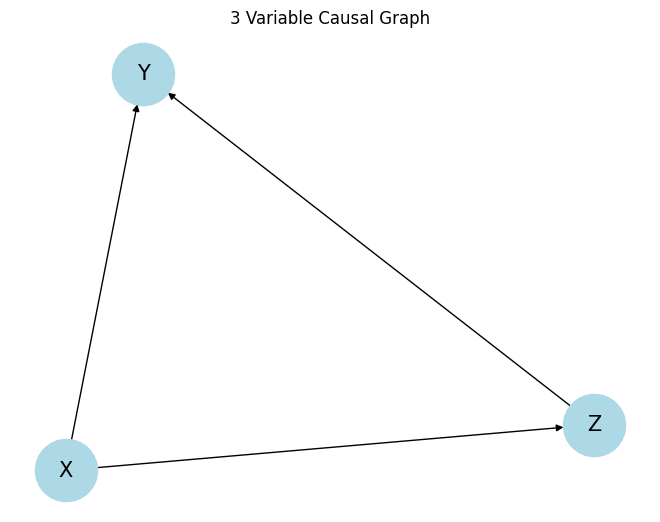

In [21]:
# Creating the causal graph
G0 = nx.DiGraph()
G0.add_edges_from([('X', 'Y'), ('Z', 'Y'), ('X', 'Z')])

# Visualizing the graph
pos = nx.spring_layout(G0)
nx.draw(G0, pos, with_labels=True, node_size=2000, node_color='lightblue', font_size=15)
plt.title("3 Variable Causal Graph")
plt.show()

In [1]:
# # Generate synthetic data, do linear regression, and plot it

# # Set a random seed for reproducibility
# np.random.seed(0)

# # Generate synthetic data
# n = 10000
# X = np.random.rand(n)
# epsilon_Z = np.random.randn(n) * 0.5  # smaller variance for the error term
# epsilon_Y = np.random.randn(n) * 0.5

# # Coefficients for the synthetic model
# beta_xz = 1.5
# beta_xy = 2.0
# beta_zy = -1.0

# # Generating Z and Y based on the model
# Z = beta_xz * X + epsilon_Z
# Y = beta_xy * X + beta_zy * Z + epsilon_Y

# # Perform linear regression to estimate the beta values

# # Prepare the data for regression
# XZ = np.column_stack((X, Z))
# XZ_with_intercept = sm.add_constant(XZ)  # add an intercept term

# # Perform linear regression for Y on X and Z
# model_Y = sm.OLS(Y, XZ_with_intercept).fit()

# # Extracting estimated coefficients
# estimated_beta_xy = model_Y.params[1]  # Coefficient for X
# estimated_beta_zy = model_Y.params[2]  # Coefficient for Z

# # The coefficient for X in the Z model needs to be estimated separately
# model_Z = sm.OLS(Z, sm.add_constant(X)).fit()
# estimated_beta_xz = model_Z.params[1]  # Coefficient for X in Z model

# # Displaying the estimated coefficients and 95% confidence interval
# estimated_beta_xy, estimated_beta_zy, estimated_beta_xz
# print(f'estimates: {estimated_beta_xy}, {estimated_beta_zy}, {estimated_beta_xz}')
# print(f'true values: {beta_xy}, {beta_zy}, {beta_xz}')
# conf_int_Y = model_Y.conf_int(alpha=0.05)  # 95% confidence interval
# print("Confidence Intervals for Y model:\n", conf_int_Y[1:3])
# conf_int_Z = model_Z.conf_int(alpha=0.05)  # 95% confidence interval
# print("\nConfidence Intervals for Z model:\n", conf_int_Z[1])

# # Plotting the data
# plt.figure(figsize=(12, 6))

# # Scatter plot for X and Y
# plt.subplot(1, 3, 1)
# plt.scatter(X, Y, alpha=0.5)
# plt.xlabel('X')
# plt.ylabel('Y')
# plt.title('Scatter plot of Y vs X')

# # Scatter plot for Z and Y
# plt.subplot(1, 3, 2)
# plt.scatter(Z, Y, alpha=0.5)
# plt.xlabel('Z')
# plt.ylabel('Y')
# plt.title('Scatter plot of Y vs Z')

# # Scatter plot for X and Z
# plt.subplot(1, 3, 3)
# plt.scatter(X, Z, alpha=0.5, color='orange')
# plt.xlabel('X')
# plt.ylabel('Z')
# plt.title('Scatter plot of Z vs X')

# plt.tight_layout()
# plt.show()

In [27]:
# from Jeremy
import numpy as np
import statsmodels.api as sm
from scipy.stats import pearsonr
from typing import List

def get_partial_regression_coefficient(X: List, Y: List, Z: List = []) -> float:
    """
    Calculate the partial regression coefficient between X and Y, controlling for variables in Z.
    
    :param X: List of values for the independent variable
    :param Y: List of values for the dependent variable
    :param Z: List of lists, where each inner list is a control variable
    :return: Partial regression coefficient
    """
    X = np.array(X)
    Y = np.array(Y)
    Z = np.column_stack(Z) if Z else np.empty((len(X), 0))

    # Add a constant to Z for the regression intercept
    Z = sm.add_constant(Z)

    # Regress Y on Z and get residuals
    model_Y = sm.OLS(Y, Z).fit()
    residual_Y = model_Y.resid

    # Regress X on Z and get residuals
    model_X = sm.OLS(X, Z).fit()
    residual_X = model_X.resid

    # Calculate the partial correlation coefficient
    r_XY_Z, _ = pearsonr(residual_X, residual_Y)

    return r_XY_Z

# Example usage
# X_data = [list of X values]
# Y_data = [list of Y values]
# Z_data = [[list of Z1 values], [list of Z2 values], ...]
# result = get_partial_regression_coefficient(X_data, Y_data, Z_data)

# A Bayesian approach to casual inference

Use a heirarchical Bayesian model:
1. observed model
2. conditioned (intervention) model

These models are coupled and share nuisance parameters and confounders. From the posterior we can get the credible region of the confounding variables (with an intervention) to check for independance/dependance. 

Example:

UPDATE and write code example


X -> Y:   Y = f(X) + epsilon

Y' = f(X')  + epsilon
Y = f(X) + epsilon

X = epsilon_x
X' = 3

X -> Z -> Y

f(X) = a*X

a ~ Normal(0, 1)

U_xy ~ Laplace(0)
 X = epsilon_x + U_xy
Y = f(X) + epsilon_y + U_xy

X, Y, Z ~ true DGP

X -> Z -> Y <- U -> X

X ~ epsilon_x + U_xy

Z ~ g(X) + epsilon_z 
Y ~ f(Z) + epsilon_y + U_xy

U_xy ~ Laplace(0)
epsilon_x, y, z ~ Normal(0,1)

g(X) = a*X,   a ~ Normal(0, 1)
f(Z)  = b*Z,   b ~ Normal(0, 1)

X' = 3
Z' = g(X') + epsilon_z
Y' = f(Z') + epsilon_y + U_xy

X' = X.copy()
do(X', {X' = 3})

Z' = Z.copy()


### Meenu's model

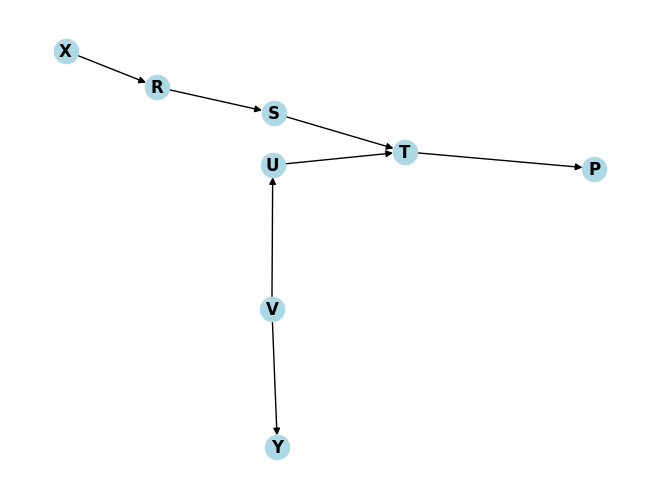

In [11]:
# graph: X -> R -> S -> T <- U <- V -> Y, T -> P
# graph edges:
# X -> R
# R -> S
# S -> T
# U -> T
# V -> U
# V -> Y
# T -> P

# Create a directed graph
G = nx.DiGraph()

# Add edges to the graph
G.add_edge('X', 'R')
G.add_edge('R', 'S')
G.add_edge('S', 'T')
G.add_edge('U', 'T')
G.add_edge('V', 'U')
G.add_edge('V', 'Y')
G.add_edge('T', 'P')

# Define the layout
pos = nx.spring_layout(G)

# Draw the graph
nx.draw(G, pos, with_labels=True, node_color='lightblue', font_weight='bold')
plt.show()

In [ ]:
# which data to generate? 
# software tools for regression analysis